In [ ]:
!pip3 install torch torchvision torchaudio


Epoch 1, Loss: 13.878334731506786
Epoch 2, Loss: 13.62257036716818
Epoch 3, Loss: 13.40117036009864
Epoch 4, Loss: 13.187968000233603
Epoch 5, Loss: 12.956956575242735
Epoch 6, Loss: 12.719764764360386
Epoch 7, Loss: 12.480211422597762
Epoch 8, Loss: 12.205218445482872
Epoch 9, Loss: 11.858290926157999
Epoch 10, Loss: 11.639890670776367
Epoch 11, Loss: 11.396884822159363
Epoch 12, Loss: 11.236868700535178
Epoch 13, Loss: 10.943208639570278
Epoch 14, Loss: 10.682612686706104
Epoch 15, Loss: 10.512988358092823
Epoch 16, Loss: 10.331171721863232
Epoch 17, Loss: 10.110570646876054
Epoch 18, Loss: 10.050635221193163
Epoch 19, Loss: 9.891937914512141
Epoch 20, Loss: 9.780087011323559
Epoch 21, Loss: 9.83005562103052
Epoch 22, Loss: 9.68522025183808
Epoch 23, Loss: 9.566310745349034
Epoch 24, Loss: 9.559406198185982
Epoch 25, Loss: 9.486115393878745
Epoch 26, Loss: 9.409070159033906
Epoch 27, Loss: 9.383133483447617
Epoch 28, Loss: 9.42096804886413
Epoch 29, Loss: 9.345443780473667
Epoch 30, 

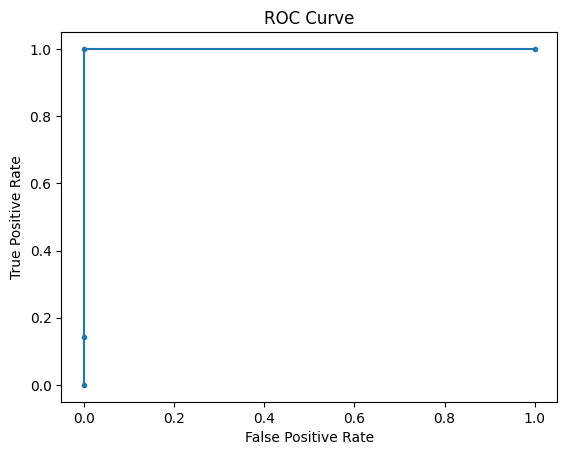

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Đọc và chuẩn bị dữ liệu
data = pd.read_csv('../../data/BCP.csv')

# Bỏ qua cột đầu tiên là ngày giờ
features = data.iloc[:, 1:]  # Bỏ cột ngày giờ nếu cần

# Chuẩn hóa các đặc trưng
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42)

# Chuyển đổi dữ liệu thành tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Định nghĩa DataLoader
train_loader = DataLoader(TensorDataset(X_train, X_train), batch_size=32, shuffle=True)

# Định nghĩa mô hình VAE với PyTorch
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU()
        )
        self.fc_mean = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mean(h), self.fc_logvar(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Khởi tạo mô hình, tiêu chuẩn và bộ tối ưu hóa
input_dim = X_train.shape[1]
latent_dim = 2
model = VAE(input_dim, latent_dim)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
epochs = 150
model.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_hat, mean, logvar = model(x)
        recon_loss = criterion(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset)}')

# Dự đoán và đánh giá
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test)
    reconstruction_loss = torch.mean((X_test - X_test_pred) ** 2, dim=1).numpy()

# Thiết lập ngưỡng để phát hiện bất thường
threshold = np.percentile(reconstruction_loss, 95)
pred_labels = (reconstruction_loss > threshold).astype(int)

# Đánh giá với ROC AUC
roc_auc = roc_auc_score(pred_labels, reconstruction_loss)
print(f'ROC AUC Score: {roc_auc}')

# Vẽ biểu đồ ROC
fpr, tpr, _ = roc_curve(pred_labels, reconstruction_loss)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


/tmp/ipykernel_2162273/1953380796.py:47: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['timestamp'] = pd.to_datetime(data['Time'])  # Chuyển đổi cột thời gian


Epoch 1, Loss: 14.506326094917629
Epoch 2, Loss: 14.495778622834578
Epoch 3, Loss: 14.547411711319633
Epoch 4, Loss: 14.60387254797894
Epoch 5, Loss: 14.509791166886039
Epoch 6, Loss: 14.348617221998131
Epoch 7, Loss: 14.482586736264436
Epoch 8, Loss: 14.395878003991168
Epoch 9, Loss: 14.331011564835258
Epoch 10, Loss: 14.366422238557234
Epoch 11, Loss: 14.205903426460598
Epoch 12, Loss: 14.235662377398947
Epoch 13, Loss: 14.160352292268172
Epoch 14, Loss: 14.169582532799762
Epoch 15, Loss: 14.15638600225034
Epoch 16, Loss: 14.20398115075153
Epoch 17, Loss: 14.059980972953465
Epoch 18, Loss: 14.099527110224185
Epoch 19, Loss: 13.958192244819973
Epoch 20, Loss: 13.874681555706522
Epoch 21, Loss: 13.949076445206352
Epoch 22, Loss: 13.937443940535836
Epoch 23, Loss: 13.84703727390455
Epoch 24, Loss: 13.843124057935631
Epoch 25, Loss: 13.765501934549082
Epoch 26, Loss: 13.745877804963484
Epoch 27, Loss: 13.856011432150137
Epoch 28, Loss: 13.71936201012653
Epoch 29, Loss: 13.693522909413213

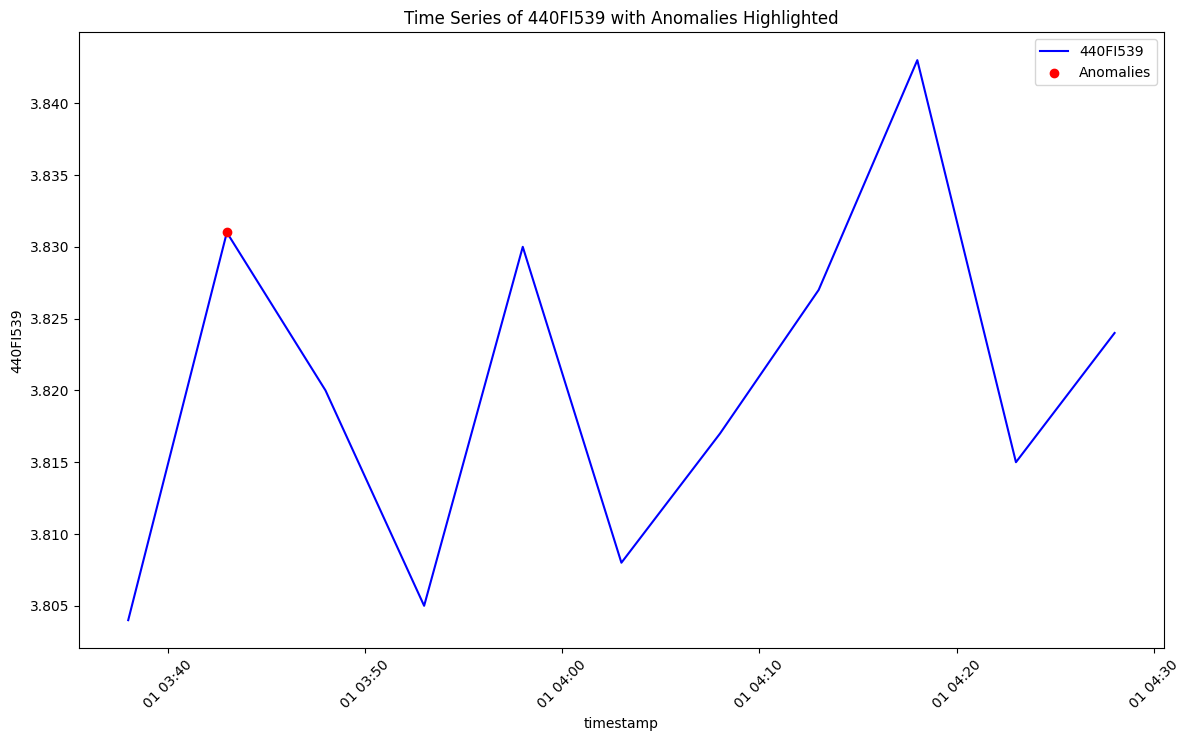

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Định nghĩa mô hình VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2_mean = nn.Linear(16, latent_dim)
        self.fc2_logvar = nn.Linear(16, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 16)
        self.fc4 = nn.Linear(16, input_dim)

    def encoder(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mean(h), self.fc2_logvar(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decoder(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z), mean, logvar

# Đọc dữ liệu từ file CSV
data = pd.read_csv('../../data/BCP.csv')


# Chọn cột để hiển thị, giả sử cột đó là '440FI540'
column_name = '440FI539'
data['timestamp'] = pd.to_datetime(data['Time'])  # Chuyển đổi cột thời gian
data.set_index('timestamp', inplace=True)

# Chuẩn hóa giá trị
scaler = StandardScaler()
data['scaled_value'] = scaler.fit_transform(data[[column_name]])

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test = train_test_split(data['scaled_value'].values, test_size=0.2)

# Đảm bảo rằng dữ liệu đầu vào có kích thước phù hợp với mô hình
input_dim = 12  # Số chiều mà mô hình mong đợi
adjusted_size_train = (len(X_train) // input_dim) * input_dim
adjusted_size_test = (len(X_test) // input_dim) * input_dim
X_train = X_train[:adjusted_size_train]
X_test = X_test[:adjusted_size_test]

# Reshape để phù hợp với mô hình
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, input_dim)
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, input_dim)

# Khởi tạo mô hình VAE, tiêu chuẩn và bộ tối ưu hóa
latent_dim = 2
model = VAE(input_dim, latent_dim)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
epochs = 50
model.train()
train_loader = DataLoader(TensorDataset(X_train, X_train), batch_size=32)
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_hat, mean, logvar = model(x)
        recon_loss = criterion(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset)}')

# Đánh giá mô hình và phát hiện bất thường
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test)
    reconstruction_loss = torch.mean((X_test - X_test_pred) ** 2, dim=1).numpy()

# Thiết lập ngưỡng để phát hiện bất thường
threshold = np.percentile(reconstruction_loss, 95)
pred_labels = (reconstruction_loss > threshold).astype(int)

# Tạo DataFrame để chứa dữ liệu và kết quả phát hiện bất thường
result_df = pd.DataFrame({
    'timestamp': data.index[-len(X_test):],  # Lấy thời gian tương ứng từ tập kiểm tra
    'value': data[column_name].values[-len(X_test):],
    'reconstruction_loss': reconstruction_loss,
    'anomaly': pred_labels
})

# Vẽ biểu đồ với các điểm bất thường
plt.figure(figsize=(14, 8))

# Vẽ biểu đồ đường cho cột đã chọn
plt.plot(result_df['timestamp'], result_df['value'], label=column_name, color='blue')

# Đánh dấu các điểm bất thường bằng scatter
anomalies = result_df[result_df['anomaly'] == 1]
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies', zorder=5)

plt.xlabel('timestamp')
plt.ylabel(column_name)
plt.title(f'Time Series of {column_name} with Anomalies Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.show()


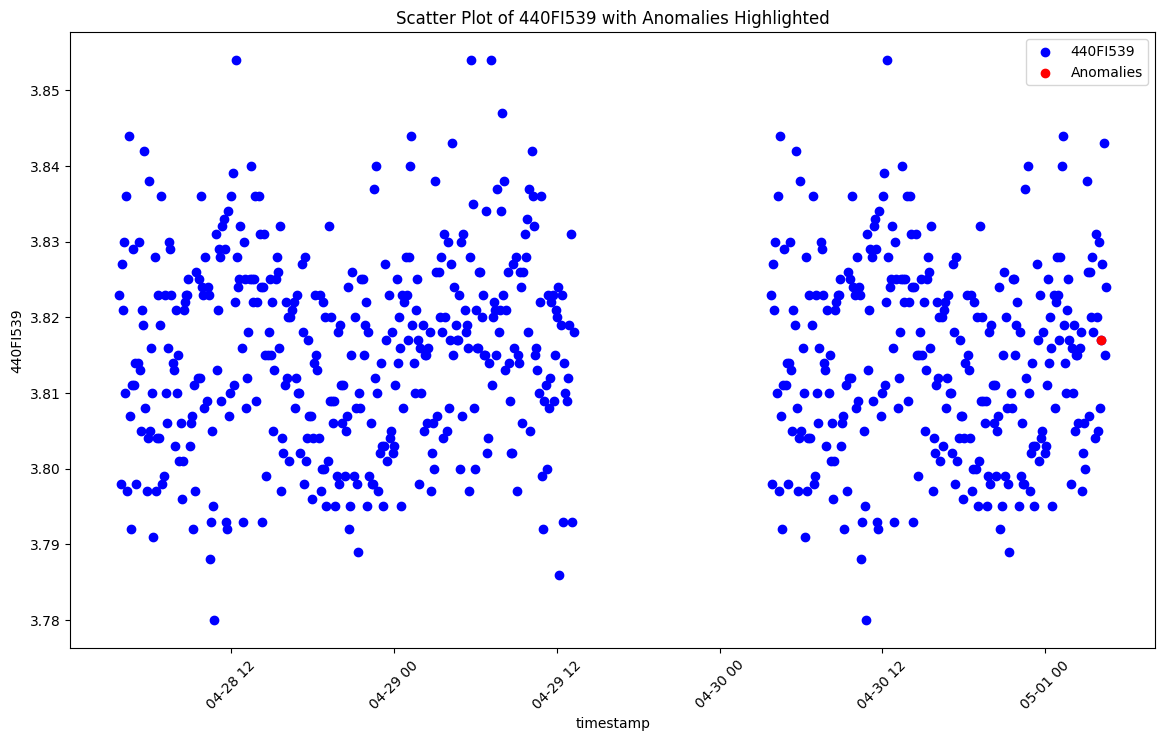

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Vẽ toàn bộ dữ liệu gốc
plt.scatter(data.index, data['440FI539'], label='440FI539', color='blue')

# Đánh dấu các điểm bất thường bằng scatter
anomalies = result_df[result_df['anomaly'] == 1]  # Chắc chắn rằng `result_df` chứa thông tin chính xác
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies', zorder=5)

plt.xlabel('timestamp')
plt.ylabel('440FI539')
plt.title('Scatter Plot of 440FI539 with Anomalies Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.show()
